In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/federica_lorenzini/ml-lab1/mlfs-book
HopsworksSettings initialized!


### Imports

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

### Connect to Hopsworks Feature Store </span>

In [4]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_BERLIN_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']

2025-11-18 11:31:29,043 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 11:31:29,121 INFO: Initializing external client
2025-11-18 11:31:29,123 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 11:31:30,868 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279175


In [5]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality_berlin',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_berlin',
    version=1,
)

In [6]:
# Select features for training data
selected_features = air_quality_fg.select(['street', 'pm25_lagged_1', 'pm25_lagged_2', 'pm25_lagged_3', 'pm25', 'date']).join(weather_fg.select_features(), on=['city'])

2025-11-18 11:34:29,562 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_berlin` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

In [7]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv_berlin',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

In [8]:
# Check Feature view
feature_view = fs.get_feature_view(name="air_quality_fv_berlin", version=1)
feature_view.schema

[Training Dataset Feature('street', 'string', 0, False, street, 1718740, None),
 Training Dataset Feature('pm25_lagged_1', 'float', 1, False, pm25_lagged_1, 1718740, None),
 Training Dataset Feature('pm25_lagged_2', 'float', 2, False, pm25_lagged_2, 1718740, None),
 Training Dataset Feature('pm25_lagged_3', 'float', 3, False, pm25_lagged_3, 1718740, None),
 Training Dataset Feature('pm25', 'float', 4, True, pm25, 1718740, None),
 Training Dataset Feature('date', 'timestamp', 5, False, date, 1718740, None),
 Training Dataset Feature('temperature_2m_mean', 'float', 6, False, temperature_2m_mean, 1724775, None),
 Training Dataset Feature('precipitation_sum', 'float', 7, False, precipitation_sum, 1724775, None),
 Training Dataset Feature('wind_speed_10m_max', 'float', 8, False, wind_speed_10m_max, 1724775, None),
 Training Dataset Feature('wind_direction_10m_dominant', 'float', 9, False, wind_direction_10m_dominant, 1724775, None)]

### Split the training data into train/test data sets </span>

In [9]:
start_date_test_data = "2025-06-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [10]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.45s) 


In [11]:
X_train

,street,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,buch,51.0,55.0,45.0,2021-04-20 00:00:00+00:00,9.537584,0.1,12.261158,346.236023
1,buch,44.0,51.0,55.0,2021-04-21 00:00:00+00:00,9.418834,0.1,20.005119,301.463257
2,buch,45.0,44.0,51.0,2021-04-22 00:00:00+00:00,6.902167,0.8,27.698954,292.953644
3,buch,34.0,45.0,44.0,2021-04-23 00:00:00+00:00,7.377167,0.0,25.488914,302.378387
4,buch,32.0,34.0,45.0,2021-04-24 00:00:00+00:00,7.156334,0.0,15.696165,310.968109
...,...,...,...,...,...,...,...,...,...
11239,neukolln-silbersteinstrasse,43.0,32.0,31.0,2025-05-31 00:00:00+00:00,19.893833,1.0,10.534229,306.869934
11240,karl-marx-strasse,41.0,27.0,30.0,2025-05-31 00:00:00+00:00,19.893833,1.0,10.534229,306.869934
11241,mitte--bruckenstrasse,38.0,22.0,25.0,2025-05-31 00:00:00+00:00,19.893833,1.0,10.534229,306.869934
11242,karl-liebknecht-strasse,46.0,33.0,33.0,2025-05-31 00:00:00+00:00,19.893833,1.0,10.534229,306.869934


In [12]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

X_features['street'] = X_features['street'].astype("category")
X_test_features['street'] = X_test_features['street'].astype("category")

X_features

,street,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,buch,51.0,55.0,45.0,9.537584,0.1,12.261158,346.236023
1,buch,44.0,51.0,55.0,9.418834,0.1,20.005119,301.463257
2,buch,45.0,44.0,51.0,6.902167,0.8,27.698954,292.953644
3,buch,34.0,45.0,44.0,7.377167,0.0,25.488914,302.378387
4,buch,32.0,34.0,45.0,7.156334,0.0,15.696165,310.968109
...,...,...,...,...,...,...,...,...
11239,neukolln-silbersteinstrasse,43.0,32.0,31.0,19.893833,1.0,10.534229,306.869934
11240,karl-marx-strasse,41.0,27.0,30.0,19.893833,1.0,10.534229,306.869934
11241,mitte--bruckenstrasse,38.0,22.0,25.0,19.893833,1.0,10.534229,306.869934
11242,karl-liebknecht-strasse,46.0,33.0,33.0,19.893833,1.0,10.534229,306.869934


In [13]:
y_train

,pm25
0,44.0
1,45.0
2,34.0
3,32.0
4,29.0
...,...
11239,45.0
11240,43.0
11241,35.0
11242,44.0


### Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [14]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(enable_categorical=True)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 110.744385
R squared: 0.3245179744688962


In [16]:
df = y_test
df['predicted_pm25'] = y_pred

In [17]:
df['date'] = X_test['date']
df['street'] = X_test['street']
df = df.sort_values(by=['date'])
df.head(11)

,pm25,predicted_pm25,date,street
11244,38.0,32.315342,2025-06-01 00:00:00+00:00,neukolln-nansenstrasse
11245,30.0,22.655352,2025-06-01 00:00:00+00:00,buch
11246,41.0,41.669476,2025-06-01 00:00:00+00:00,neukolln-silbersteinstrasse
11247,40.0,32.994892,2025-06-01 00:00:00+00:00,leipziger-strasse
11248,43.0,41.779598,2025-06-01 00:00:00+00:00,mariendorf--mariendorfer-damm
11249,41.0,40.613251,2025-06-01 00:00:00+00:00,karl-marx-strasse
11250,34.0,22.804350,2025-06-01 00:00:00+00:00,wedding-amrumer-strasse
11251,40.0,40.157497,2025-06-01 00:00:00+00:00,friedrichshagen
11252,35.0,25.218281,2025-06-01 00:00:00+00:00,mitte--bruckenstrasse
11253,41.0,41.466171,2025-06-01 00:00:00+00:00,karl-liebknecht-strasse


In [18]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model_berlin"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

### Extract Streets

In [19]:
metadata = pd.DataFrame()
metadata['street'] = df['street'].drop_duplicates()  
metadata

,street
11244,neukolln-nansenstrasse
11245,buch
11246,neukolln-silbersteinstrasse
11247,leipziger-strasse
11248,mariendorf--mariendorfer-damm
11249,karl-marx-strasse
11250,wedding-amrumer-strasse
11251,friedrichshagen
11252,mitte--bruckenstrasse
11253,karl-liebknecht-strasse


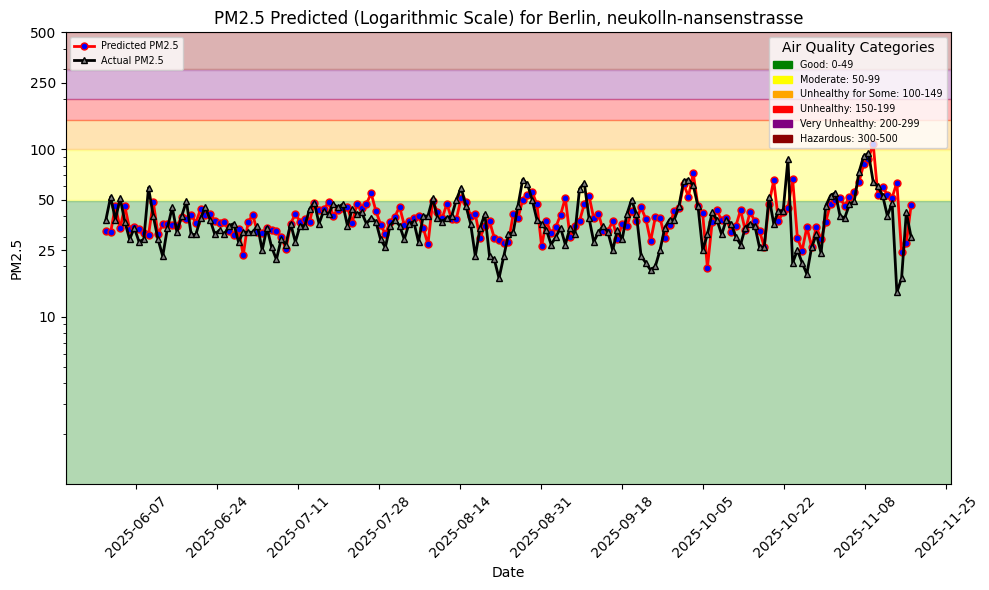

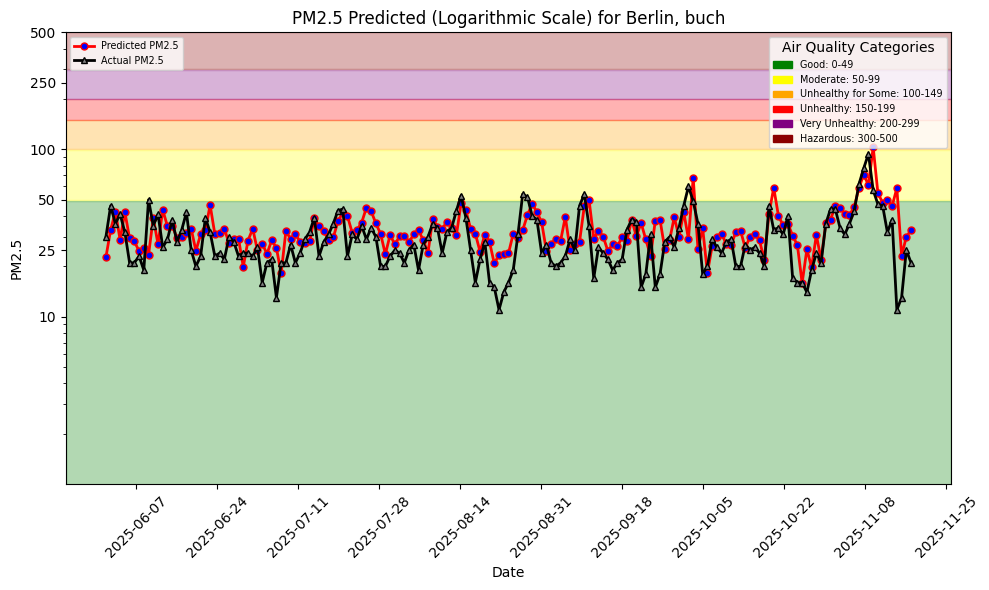

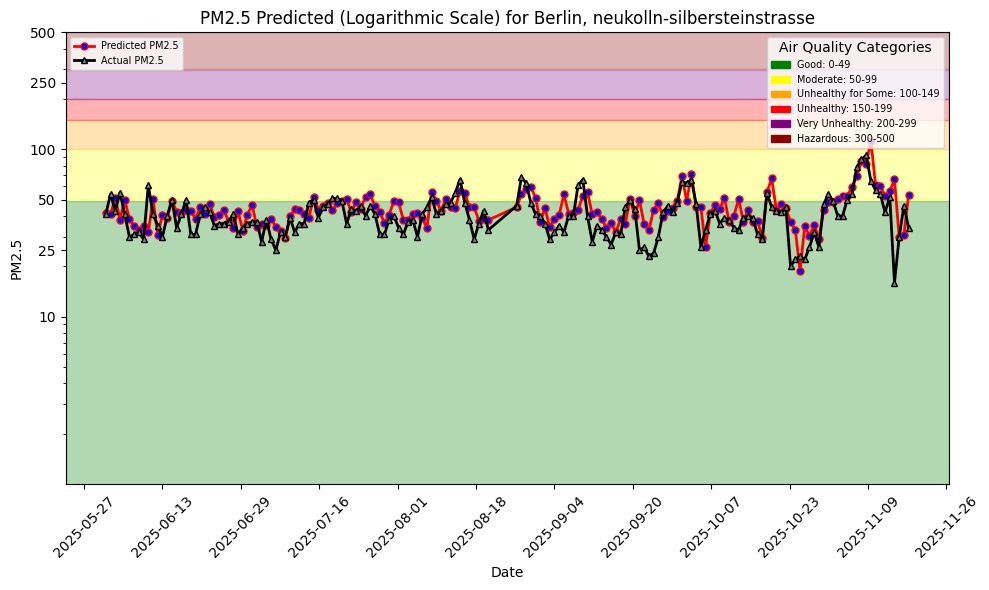

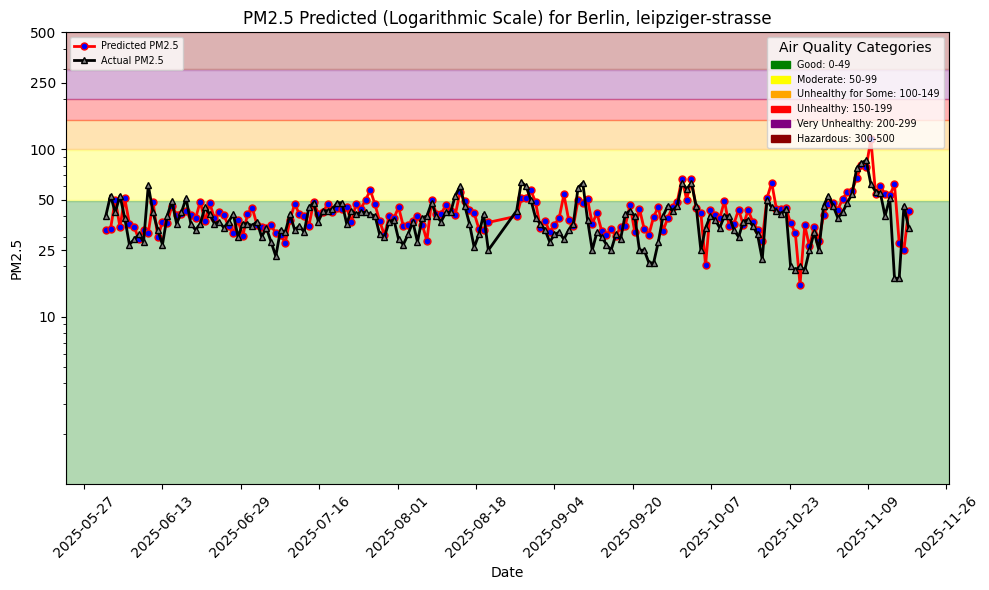

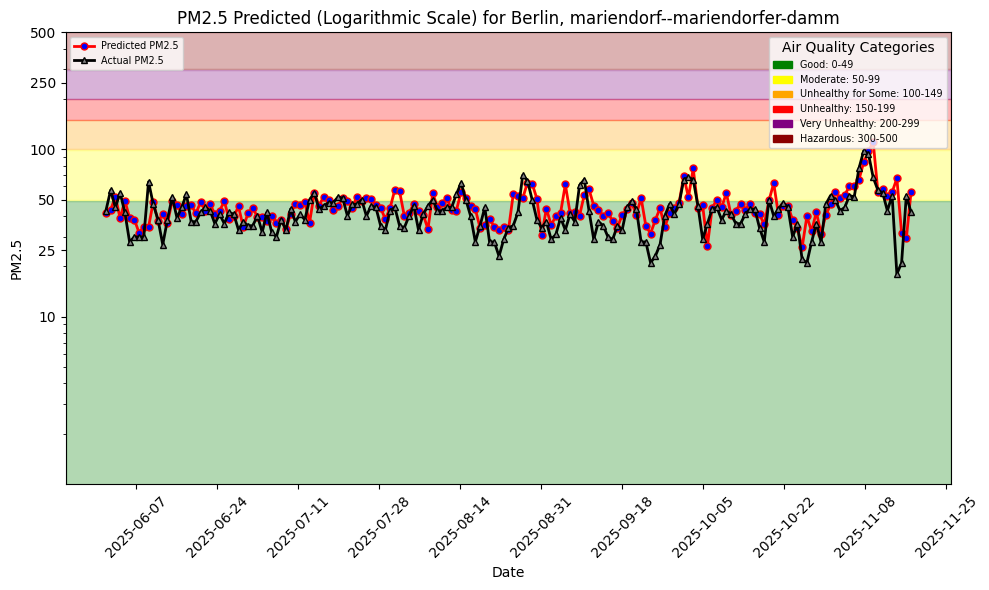

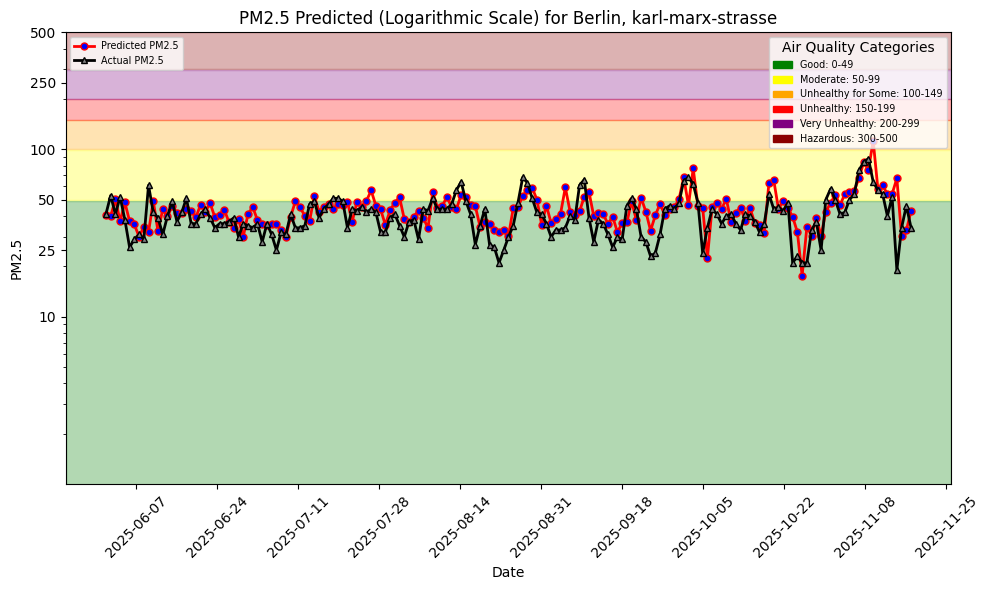

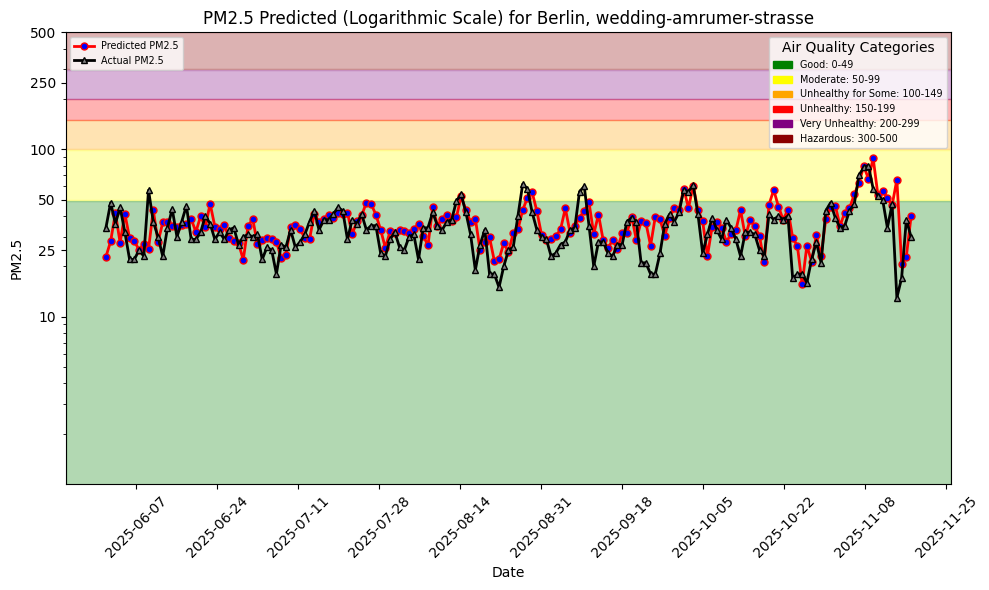

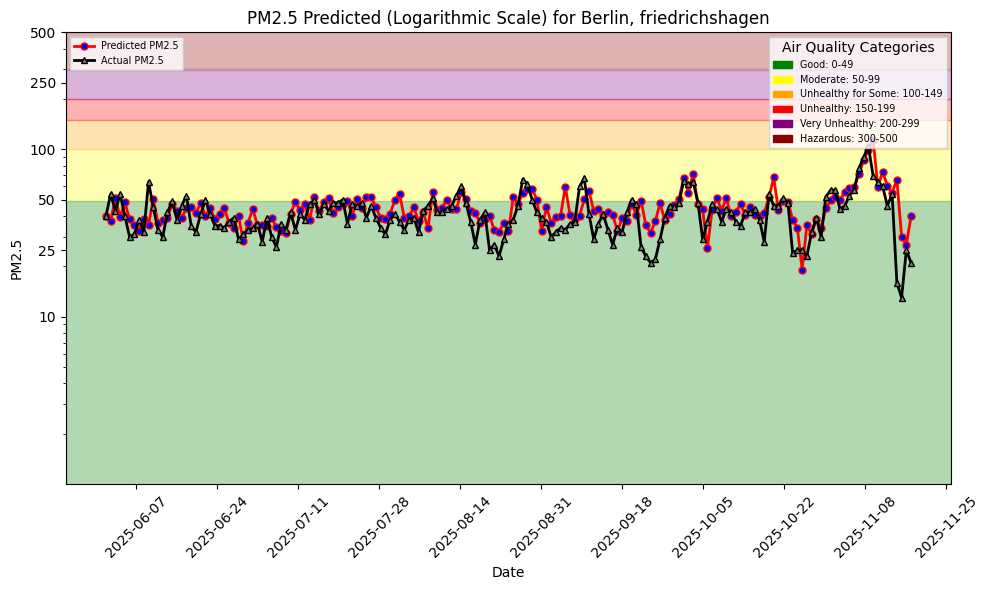

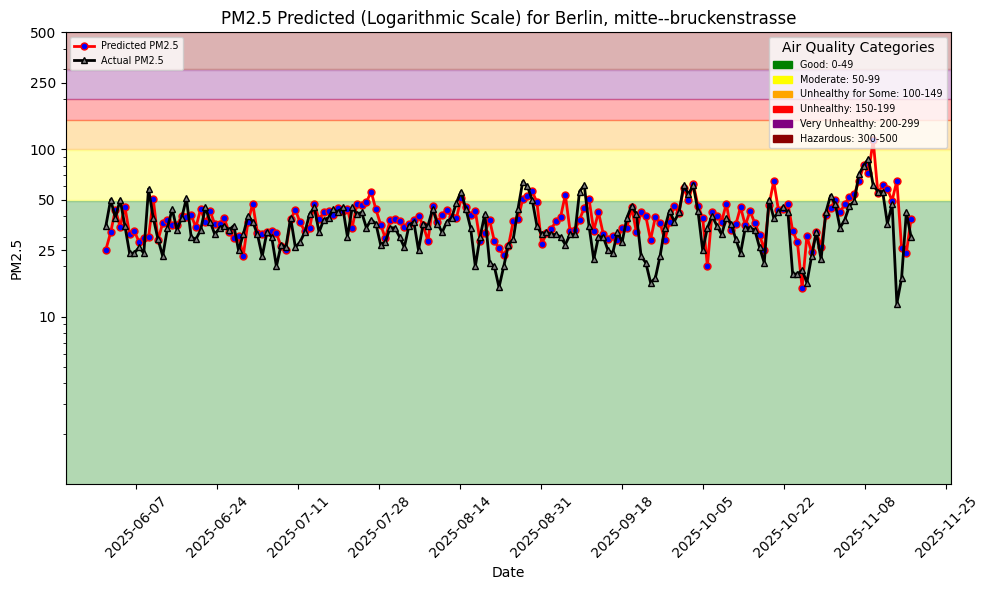

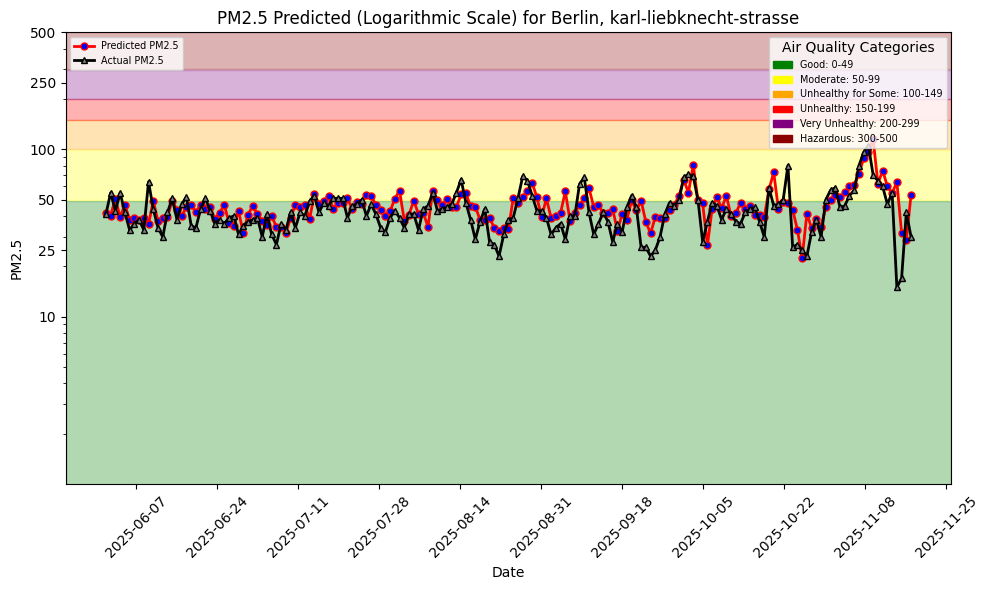

In [20]:
for i in range(metadata.shape[0]):
    street = metadata.iloc[i]['street']

    file_path = images_dir + "/pm25_hindcast_" + street + ".png"
    df_i = df[df['street'] == street]
    plt = util.plot_air_quality_forecast(city, street, df_i, file_path, hindcast=True) 
    plt.show()

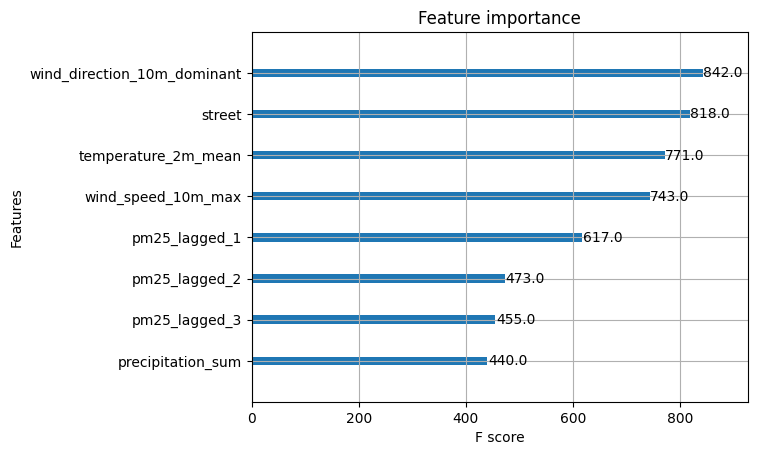

In [21]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

### Model Registry

In [22]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model_berlin.json")

In [23]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [24]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model_berlin", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor for Berlin",
)

# Saving the model artifacts to the 'air_quality_model_berlin' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/notebooks/airquality/air_quality_model_berlin/model_berli…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/notebooks/airquality/air_quality_model_berlin/images/feat…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/notebooks/airquality/air_quality_model_berlin/images/pm25…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/notebooks/airquality/air_quality_model_berlin/images/pm25…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/notebooks/airquality/air_quality_model_berlin/images/pm25…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/notebooks/airquality/air_quality_model_berlin/images/pm25…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/notebooks/airquality/air_quality_model_berlin/images/pm25…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/notebooks/airquality/air_quality_model_berlin/images/pm25…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/notebooks/airquality/air_quality_model_berlin/images/pm25…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/notebooks/airquality/air_quality_model_berlin/images/pm25…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/notebooks/airquality/air_quality_model_berlin/images/pm25…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/notebooks/airquality/air_quality_model_berlin/images/pm25…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/notebooks/airquality/model_schema.json: 0.000%|          …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279175/models/air_quality_xgboost_model_berlin/2


Model(name: 'air_quality_xgboost_model_berlin', version: 2)